This notebook is to confirm scaling/normalization of 2DETBRT and 2SHLDBRT for HRC for the purpose of Snapshot page display, following the HRC anomaly and switch to the B-side elctronics. The check is performed based on the A-side data recorded prior to the anomaly.

__Method:__
* fetch values for 2DETART and 2SHLDART from the Chandra Snapshot archive snarc.tmp (built with a custom MTA IPCL and so normalized)
* fetch the same MSIDs for the same time period from maude (not normalized)
* set the maude MSIDs to zero when in the radzone
* compare the Snapshot values with maude values altered as follows:
  * ``shldart_maude // 256``, i.e floor division
  * ``floor(log2(detart_maude + 1))``, i.e. the highest power of 2. __NOTE:__ not sure why I need to add 1 but without it the comparison does not work
  
__Next steps:__
* update Snapshot accordingly, the best place might be the ``comps.pm`` module
* activate the HRC SHIELD alert in the ``check_state.pm`` module
* update acorn so that it uses the DS installed IPCL database instead of the local MTA database (this is not critical as the current local MTA IPCL does not perform any scaling for the B-side MSIDs)

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from Chandra.Time import DateTime
from astropy.io import ascii
from Ska.Matplotlib import plot_cxctime
from Ska.engarchive import fetch as fetch
from Ska.Numpy import interpolate
from math import log, ceil, floor
from kadi import events

__Fetch 2DETART and 2SHLDART from maude__

In [2]:
start = '2020:052'   # the earlierst time in Snapshot archive
stop = '2020:235'    # time before the HRC anomaly

In [3]:
shldart_maude = fetch.Msid('2shldart', start=start, stop=stop)

In [4]:
detart_maude = fetch.MSID("2detart", start=start, stop=stop)

In [5]:
radzones = events.rad_zones.filter(start=start, stop=stop)

In [6]:
def zero_msid_in_radzones(msid, radzones):
    # Alters msid in place
    for radzone in radzones:
        t0, t1 = DateTime(radzone.start).secs, DateTime(radzone.stop).secs
        ok = (msid.times > t0) & (msid.times <= t1)
        if np.any(ok):
            msid.vals[ok] = 0

In [7]:
zero_msid_in_radzones(shldart_maude, radzones)

In [8]:
zero_msid_in_radzones(detart_maude, radzones)

__Read in 2DETART and 2SHLDART from Snapshot archive__

In [9]:
dat = ascii.read('aside-test.dat')

In [10]:
dat = Table(dat)

In [11]:
times_snap = DateTime(dat['col1'][::-1]).secs[:30000]
detart_snap = dat['col2'][::-1][:30000]
shldart_snap = dat['col3'][::-1][:30000]

__Maude data are fetched every ~8 sec, Snapshot data were recorded every ~1 minute. Interpolate maude data on the time axis of the Snapshot data:__

In [12]:
y_out_shldart = interpolate(shldart_maude.vals, shldart_maude.times, times_snap, method='nearest')
y_out_detart = interpolate(detart_maude.vals, detart_maude.times, times_snap, method='nearest')

__Compare side-A 2SHLDART from maude and Snapshot__

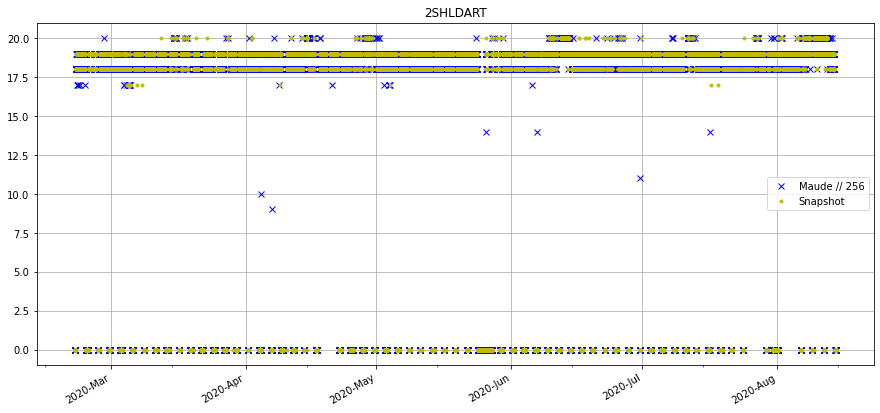

In [13]:
plt.figure(figsize=(15, 7))
plot_cxctime(times_snap, y_out_shldart // 256,
             'b', marker='x', linestyle='None', label='Maude // 256');
plot_cxctime(times_snap, shldart_snap,
             'y', marker='.', linestyle='None', label='Snapshot')
plt.grid()
plt.title('2SHLDART')
plt.legend();

In [14]:
vals = shldart_snap - (y_out_shldart // 256)

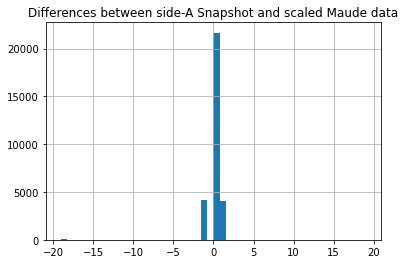

In [15]:
plt.hist(vals, bins=50)
plt.title('Differences between side-A Snapshot and scaled Maude data')
plt.grid();

__Compare side-A 2DETART from maude and Snapshot__

In [16]:
def highest_power(x):
    highest_powers = []
    for xx in x:
        val = floor(log(xx, 2))
        highest_powers.append(val)
    return np.array(highest_powers)

"2DETART",1,1,0,255.0

"2DETART",1,2,255,65279.0

In [17]:
highest_powers = highest_power(y_out_detart + 1)

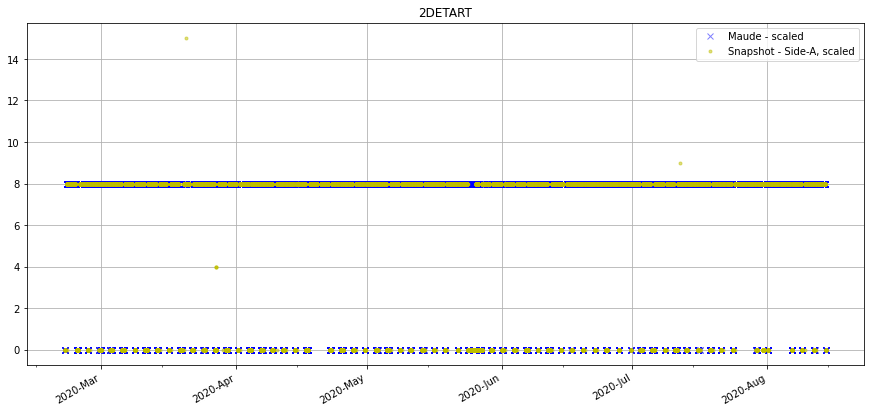

In [18]:
plt.figure(figsize=(15, 7))
plot_cxctime(times_snap, highest_powers,
             'b', marker='x', linestyle='None', alpha=0.5, label='Maude - scaled')
plot_cxctime(times_snap[:30000], detart_snap[:30000],
             'y', marker='.', linestyle='None', alpha=0.5, label='Snapshot - Side-A, scaled')
plt.grid()
plt.legend()
plt.title('2DETART');

In [19]:
vals = detart_snap - highest_powers

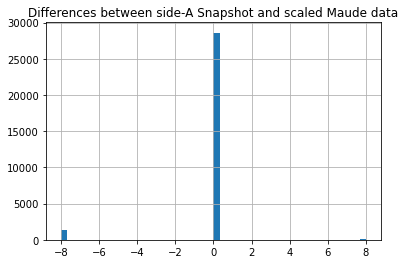

In [20]:
plt.hist(vals, bins=50)
plt.title('Differences between side-A Snapshot and scaled Maude data')
plt.grid();